In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB # or GaussianNB if your data is normalized and continuous
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import zipfile

# Paths to your uploaded files
zip_file_path_KO = 'terms_KO.zip'
csv_file_name_KO = 'terms_KO.csv'
zip_file_path_traits = 'reducedDataset.zip'
csv_file_name_traits = 'reducedDataset.csv'

# Read and preprocess KO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='KO', values='value', fill_value=0)

# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0)
X_filtered = selector.fit_transform(X_terms)
X_filtered_df = pd.DataFrame(X_filtered, index=X_terms.index, columns=X_terms.columns[selector.get_support()])

# Optionally, inspect the variance of features to confirm removal
feature_variances = X_filtered_df.var()
print(f"Features with zero variance after filtering: {sum(feature_variances == 0)}")

# Read and preprocess traits data
with zipfile.ZipFile(zip_file_path_traits, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_traits) as file:
        traits = pd.read_csv(file, sep=';')
traits['oxygen'] = traits['oxygen'].str.lower()

# Mapping of oxygen levels to a simplified classification
oxygen_mapping = {
    'aerobic': 'aerobic',
    'aerotolerant': 'aerobic',
    'microaerophilic': 'aerobic',
    'obligate aerobic': 'aerobic',
    'anaerobic': 'anaerobic',
    'obligate anaerobic': 'anaerobic',
    'conflict': 'aerobic',  # This should be checked
    'facultative': 'aerobic'  # This should also be checked
}
traits['oxygen'] = traits['oxygen'].map(oxygen_mapping)

# Handling missing values and aggregating by key
y = traits.dropna(subset=['oxygen']).groupby('key').agg({'oxygen': lambda x: x.value_counts().index[0]})

# Find common keys after removing missing values
common_keys = X_filtered_df.index.intersection(y.index)

# Align X (features) and Y (labels) based on common keys
X_aligned = X_filtered_df.loc[common_keys]
Y_aligned = y.loc[common_keys].values.ravel()

# Ensures X_aligned and Y_aligned are aligned
assert X_aligned.shape[0] == len(Y_aligned), "X and Y are not aligned"




Features with zero variance after filtering: 0


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


C:\Users\eliah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [   43   184   327   370   378   385   413   523   531   536   579   655
   662   837   855   888   935   943   945   948   970   980  1085  1213
  1390  1546  1576  1578  1945  1950  2079  2087  2156  2290  2792  2800
  2834  2854  2855  2964  2976  2986  3092  3099  3106  3107  3108  3109
  3110  3113  3114  3118  3122  3170  3191  3249  3274  3275  3513  3551
  3554  3555  3632  3637  3697  3710  3714  3717  4006  4079  4121  4186
  4221  4246  4247  4490  4541  4556  4561  4562  4584  4620  4643  4715
  4716  4741  4801  4814  4838  4962  5002  5025  5030  5037  5179  5355
  5356  5357  5396  5397  5398  5441  5443  5446  5447  5455  5521  5534
  5554  5557  5562  5569  5579  5583  5610  5611  5617  5636  5661  5707
  5745  5749  5751  5763  5798  5828  5839  5972  598

Best parameters found: {'gnb__var_smoothing': 1.0, 'select_k__k': 20}
Best cross-validation score: 0.921
Accuracy on test set: 0.9263050153531218
Classification Report:
               precision    recall  f1-score   support

     aerobic       0.97      0.94      0.95       795
   anaerobic       0.77      0.86      0.81       182

    accuracy                           0.93       977
   macro avg       0.87      0.90      0.88       977
weighted avg       0.93      0.93      0.93       977



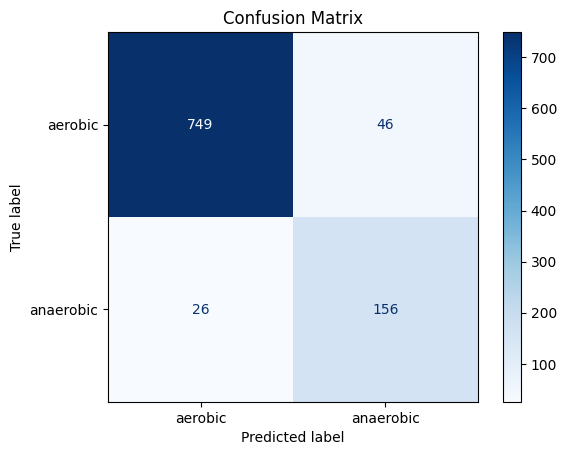

Confusion matrix, without normalization
[[749  46]
 [ 26 156]]
Normalized confusion matrix
[[0.94213836 0.05786164]
 [0.14285714 0.85714286]]


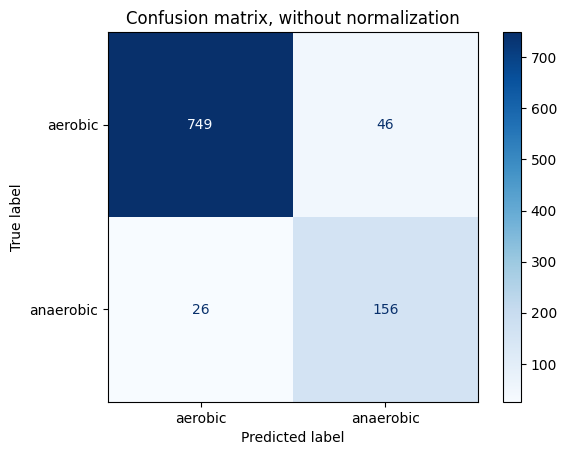

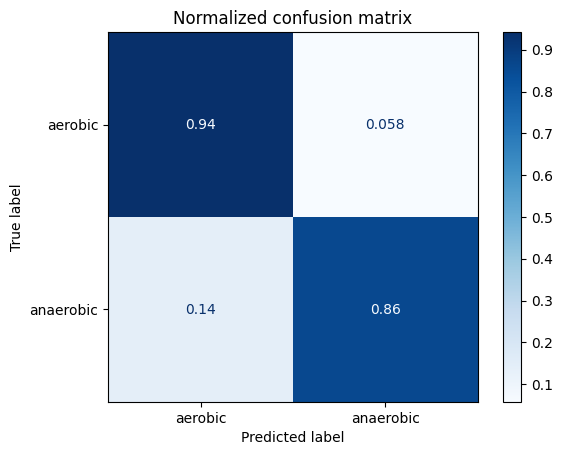

In [58]:
pipeline = Pipeline([
    ('select_k', SelectKBest(f_classif)),
    ('gnb', GaussianNB())
])

# Define a parameter grid to search over
param_grid = {
    'select_k__k': [10, 20, 30],  # Example values, adjust based on your dataset
    'gnb__var_smoothing': np.logspace(0, -9, num=100)
}

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_aligned, Y_aligned, test_size=0.3, random_state=42)

# Set up GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, Y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)

# Calculate accuracy and other metrics as needed
print("Accuracy on test set:", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))
# Confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, cmap=plt.cm.Blues, normalize=None)
disp.ax_.set_title("Confusion Matrix")
plt.show()


# Confusion Matrix Display
titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", "true")]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()